#### pre-processing

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import time
import torch.nn.functional as F
import os
# !pip install ptflops
# from ptflops import get_model_complexity_info
# !pip install wget
# import wget
# !pip install requests gdown
# import gdown

In [2]:
# Hyper-parameter and setting
image_size = 224
batch_size = 16
channel_size = 3
lr = 1e-3
num_epochs_student = 1
num_classes = 10

# var init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(123)

In [3]:
# Data pre-processing of source and target domain
tf_source = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.1307,],  # Normalization as MNIST setting
                        std=[0.30,],
                        )
])

tf_target = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.5, 0.5, 0.5],  # Normalization as default setting
                        std=[0.5, 0.5, 0.5],
                        )
])

########################################################################################
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Dataset and dataloader source & target domain (train_set)
# Ds_source = datasets.MNIST(root='Dataset/mnist_dataset/', download=True, train=True, transform=tf_source)
# Dl_source = DataLoader(Ds_source, batch_size, shuffle=True, num_workers=2)

# Download here: https://drive.google.com/drive/folders/14IgFgyHyJ3I8-VPzzA33sBF1w2E1mVVt?usp=sharing
# Mount and unzip from directory
# from google.colab import drive
# drive.mount('./drive/')
# !unzip './drive/MyDrive/99H_datasets/MNIST_M.zip'
# Upload directly
# !unzip './MNIST_M.zip'

# Ds_target = datasets.ImageFolder(root='./MNIST_M/train', transform=tf_target)
# Dl_target = DataLoader(Ds_target, batch_size, shuffle=True, num_workers=2)
# train_split = 0.8
# train_size = int(train_split * len(Dl_target))
# test_size = len(Dl_target) - train_size
# Dl_tar_training_set, Dl_tar_testing_set = torch.utils.data.random_split(Dl_target, [train_size, test_size])
Ds_target_train = datasets.ImageFolder(root='/home/crueang/Chaks/AIOT/data/MNIST_M/train', transform=tf_target)
Dl_tar_training_set = DataLoader(Ds_target_train, batch_size, shuffle=True, num_workers=2)
Ds_target_test = datasets.ImageFolder(root='/home/crueang/Chaks/AIOT/data/MNIST_M/test', transform=tf_target)
Dl_tar_testing_set = DataLoader(Ds_target_test, batch_size, shuffle=False, num_workers=2)

def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_student_acc"], label="Train")
    ax1.plot(history["val_student_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_student_loss"], label="Train")
    ax2.plot(history["val_student_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [4]:
# @title FLOPS computation
# Code from https://github.com/Eric-mingjie/rethinking-network-pruning/blob/master/imagenet/l1-norm-pruning/compute_flops.py
import numpy as np
import os

import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable


def print_model_param_nums(model=None):
    if model == None:
        model = torchvision.models.alexnet()
    total = sum([param.nelement() if param.requires_grad else 0 for param in model.parameters()])
    print('  + Number of params: %.4fM' % (total / 1e6))

def count_model_param_flops(model=None, input_res=224, multiply_adds=True):

    prods = {}
    def save_hook(name):
        def hook_per(self, input, output):
            prods[name] = np.prod(input[0].shape)
        return hook_per

    list_1=[]
    def simple_hook(self, input, output):
        list_1.append(np.prod(input[0].shape))
    list_2={}
    def simple_hook2(self, input, output):
        list_2['names'] = np.prod(input[0].shape)


    list_conv=[]
    def conv_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = self.kernel_size[0] * self.kernel_size[1] * (self.in_channels / self.groups)
        bias_ops = 1 if self.bias is not None else 0

        params = output_channels * (kernel_ops + bias_ops)
        # flops = (kernel_ops * (2 if multiply_adds else 1) + bias_ops) * output_channels * output_height * output_width * batch_size

        num_weight_params = (self.weight.data != 0).float().sum()
        flops = (num_weight_params * (2 if multiply_adds else 1) + bias_ops * output_channels) * output_height * output_width * batch_size

        list_conv.append(flops)

    list_linear=[]
    def linear_hook(self, input, output):
        batch_size = input[0].size(0) if input[0].dim() == 2 else 1

        weight_ops = self.weight.nelement() * (2 if multiply_adds else 1)
        bias_ops = self.bias.nelement()

        flops = batch_size * (weight_ops + bias_ops)
        list_linear.append(flops)

    list_bn=[]
    def bn_hook(self, input, output):
        list_bn.append(input[0].nelement() * 2)

    list_relu=[]
    def relu_hook(self, input, output):
        list_relu.append(input[0].nelement())

    list_pooling=[]
    def pooling_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = self.kernel_size * self.kernel_size
        bias_ops = 0
        params = 0
        flops = (kernel_ops + bias_ops) * output_channels * output_height * output_width * batch_size

        list_pooling.append(flops)

    list_upsample=[]

    # For bilinear upsample
    def upsample_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        flops = output_height * output_width * output_channels * batch_size * 12
        list_upsample.append(flops)

    def foo(net):
        childrens = list(net.children())
        if not childrens:
            if isinstance(net, torch.nn.Conv2d):
                net.register_forward_hook(conv_hook)
            if isinstance(net, torch.nn.Linear):
                net.register_forward_hook(linear_hook)
            if isinstance(net, torch.nn.BatchNorm2d):
                net.register_forward_hook(bn_hook)
            if isinstance(net, torch.nn.ReLU):
                net.register_forward_hook(relu_hook)
            if isinstance(net, torch.nn.MaxPool2d) or isinstance(net, torch.nn.AvgPool2d):
                net.register_forward_hook(pooling_hook)
            if isinstance(net, torch.nn.Upsample):
                net.register_forward_hook(upsample_hook)
            return
        for c in childrens:
            foo(c)

    if model == None:
        model = torchvision.models.alexnet()
    foo(model)
    input = Variable(torch.rand(3,input_res,input_res).unsqueeze(0), requires_grad = True)
    out = model(input)


    total_flops = (sum(list_conv) + sum(list_linear) + sum(list_bn) + sum(list_relu) + sum(list_pooling) + sum(list_upsample))

    print('Number of FLOPs: %.6f GFLOPs (%.2f MFLOPs)' % (total_flops / 1e9, total_flops / 1e6))

    return total_flops

In [5]:
class ptsq_VGG_model(nn.Module):
    def __init__(self, n_C=10):
        super(ptsq_VGG_model, self).__init__()
        # QuantStub converts tensors from floating point to quantized
        self.quant = torch.ao.quantization.QuantStub()

        self.VGG = torchvision.models.vgg16(pretrained=True)
        self.VGG.classifier[-1] = nn.Linear(in_features=4096, out_features=10)
        # DeQuantStub converts tensors from quantized to floating point
        self.dequant = torch.ao.quantization.DeQuantStub()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):

        # Handle single-channel input by expanding (repeating) the singleton dimension
        # MNIST (grayscale, 1-channel) to 3-channel
        x = x.expand(x.data.shape[0], channel_size, image_size, image_size).to(device)
        # print(x.shape)
        x = self.quant(x)
        
        x = self.VGG(x)
        
        x = self.dequant(x)
        x = self.logsoftmax(x)
        return x

In [6]:
# create a model instance
device = 'cpu'
model_ptdq_fp32 = ptsq_VGG_model().to(device)
# create a quantized model instance
model_ptdq_int8 = torch.ao.quantization.quantize_dynamic(
    model_ptdq_fp32,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

# run the model
input_fp32 = torch.randn(1, 3, 224, 224)
res = model_ptdq_int8(input_fp32)
summary(model_ptdq_int8, input_size=(channel_size, image_size, image_size))
count_model_param_flops(model=model_ptdq_int8.eval(), input_res=image_size, multiply_adds=True)

/home/crueang/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/crueang/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         QuantStub-1          [-1, 3, 224, 224]               0
            Conv2d-2         [-1, 64, 224, 224]           1,792
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
              ReLU-5         [-1, 64, 224, 224]               0
         MaxPool2d-6         [-1, 64, 112, 112]               0
            Conv2d-7        [-1, 128, 112, 112]          73,856
              ReLU-8        [-1, 128, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]         147,584
             ReLU-10        [-1, 128, 112, 112]               0
        MaxPool2d-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         295,168
             ReLU-13          [-1, 256, 56, 56]               0
           Conv2d-14          [-1, 256,

tensor(3.0726e+10)

#### Post Training Static Quantization (i.e., PTSQ)

Post Training Static Quantization (PTQ static) quantizes the weights and activations of the model. It fuses activations into preceding layers where possible. It requires calibration with a representative dataset to determine optimal quantization parameters for activations. Post Training Static Quantization is typically used when both memory bandwidth and compute savings are important with CNNs being a typical use case.



```
# original model
# all tensors and computations are in floating point
previous_layer_fp32 -- linear_fp32 -- activation_fp32 -- next_layer_fp32
                    /
    linear_weight_fp32

# statically quantized model
# weights and activations are in int8
previous_layer_int8 -- linear_with_activation_int8 -- next_layer_int8
                    /
  linear_weight_int8
```



In [7]:
import torch

# define a floating point model where some layers could be statically quantized
class ptsq_student_model(nn.Module):
    def __init__(self, n_C=10):
        super(ptsq_student_model, self).__init__()
        # QuantStub converts tensors from floating point to quantized
        self.quant = torch.ao.quantization.QuantStub()

        self.conv1 = nn.Conv2d(3, 32, kernel_size = 5)
        self.batchnorm2d_1 = nn.BatchNorm2d(32)
        self.relu_1 = nn.ReLU()
        self.maxpool2d_1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5)
        self.batchnorm2d_2 = nn.BatchNorm2d(64)
        self.relu_2 = nn.ReLU()
        self.maxpool2d_2 = nn.MaxPool2d(2)

        # Expand from one extractor to two extractor (classed and domain-classed)
        self.num_cnn_features = 64 * 4 * 4  # 1024 flattening

        # Label classification (blue section)
        self.linear_1 = nn.Linear(self.num_cnn_features, 64)
        # self.batchnorm1d = nn.BatchNorm1d(64)
        self.relu_lin1 = nn.ReLU()
        # self.dropout = nn.Dropout()

        # output logits layer (10 classes)
        self.linear_2 = nn.Linear(64, n_C)
        self.logsoftmax = nn.LogSoftmax(dim=1)

        # DeQuantStub converts tensors from quantized to floating point
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):

        # Handle single-channel input by expanding (repeating) the singleton dimension
        # MNIST (grayscale, 1-channel) to 3-channel
        x = x.expand(x.data.shape[0], channel_size, image_size, image_size)
        # print(x.shape)
        x = self.quant(x)
        x = self.maxpool2d_1(self.relu_1(self.batchnorm2d_1(self.conv1(x))))
        x = self.maxpool2d_2(self.relu_2(self.batchnorm2d_2(self.conv2(x))))
        fc = x.reshape(-1, self.num_cnn_features) #Flattening
        fc = self.relu_lin1(self.linear_1(fc))  #regular features classification
        logits = self.linear_2(fc)
        logits = self.dequant(logits)
        out = self.logsoftmax(logits)
        return out

# create a model instance
model_fp32_ptsq = ptsq_student_model()

# model must be set to eval mode for static quantization logic to work
model_fp32_ptsq.eval()

# attach a global qconfig, which contains information about what kind
# of observers to attach. Use 'x86' for server inference and 'qnnpack'
# for mobile inference. Other quantization configurations such as selecting
# symmetric or asymmetric quantization and MinMax or L2Norm calibration techniques
# can be specified here.
# Note: the old 'fbgemm' is still available but 'x86' is the recommended default
# for server inference.
# model_fp32_ptsq.qconfig = torch.ao.quantization.get_default_qconfig('fbgemm')
model_fp32_ptsq.qconfig = torch.ao.quantization.get_default_qconfig('x86')
# model_fp32_ptsq.qconfig = torch.ao.quantization.get_default_qconfig('qnnpack')

# Fuse the activations to preceding layers, where applicable.
# This needs to be done manually depending on the model architecture.
# Common fusions include `conv + relu` and `conv + batchnorm + relu`
model_fp32_ptsq_fused = torch.ao.quantization.fuse_modules(model_fp32_ptsq,
                                                      [['conv1', 'batchnorm2d_1', 'relu_1'],
                                                       ['conv2', 'batchnorm2d_2', 'relu_2'],
                                                       ['linear_1', 'relu_lin1'],
                                                      #  ['linear_2']
                                                       ])

# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
model_fp32_ptsq_prepared = torch.ao.quantization.prepare(model_fp32_ptsq_fused)

# calibrate the prepared model to determine quantization parameters for activations
# in a real world setting, the calibration would be done with a representative dataset
input_fp32 = torch.randn(4, 3, 28, 28)
model_fp32_ptsq_prepared(input_fp32)

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
model_ptsq_int8 = torch.ao.quantization.convert(model_fp32_ptsq_prepared)




# run the model, relevant calculations will happen in int8
res = model_ptsq_int8(input_fp32)
# summary(model_int8, input_size=(channel_size, image_size, image_size))
# Print the total number of parameters directly (no need for .numpy() anymore)
print(f'int8 ptsq model: {model_ptsq_int8}')
print(f'\n\n\nint8 qat model: {model_ptsq_int8}')
total_params = sum(p.numel() for p in model_ptsq_int8.parameters())
print("\n\n\nTotal parameters of Post Training Static Quantization (i.e., PTSQ):", total_params)
count_model_param_flops(model=model_ptsq_int8.eval(), input_res=28, multiply_adds=True)

/home/crueang/anaconda3/lib/python3.11/site-packages/torch/ao/quantization/observer.py:221: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


RuntimeError: The expanded size of the tensor (224) must match the existing size (28) at non-singleton dimension 3.  Target sizes: [4, 3, 224, 224].  Tensor sizes: [4, 3, 28, 28]

#### Quantization Aware Training (QAT) for Static Quantization

Core idea = Quantization + Fine-Tuning (FT)\
\
Quantization Aware Training (QAT) models the effects of quantization during training allowing for higher accuracy compared to other quantization methods. We can do QAT for static, dynamic or weight only quantization. During training, all calculations are done in floating point, with fake_quant modules modeling the effects of quantization by clamping and rounding to simulate the effects of INT8. After model conversion, weights and activations are quantized, and activations are fused into the preceding layer where possible. It is commonly used with CNNs and yields a higher accuracy compared to static quantization.



```
# original model
# all tensors and computations are in floating point
previous_layer_fp32 -- linear_fp32 -- activation_fp32 -- next_layer_fp32
                      /
    linear_weight_fp32

# model with fake_quants for modeling quantization numerics during training
previous_layer_fp32 -- fq -- linear_fp32 -- activation_fp32 -- fq -- next_layer_fp32
                           /
   linear_weight_fp32 -- fq

# quantized model
# weights and activations are in int8
previous_layer_int8 -- linear_with_activation_int8 -- next_layer_int8
                     /
   linear_weight_int8
```



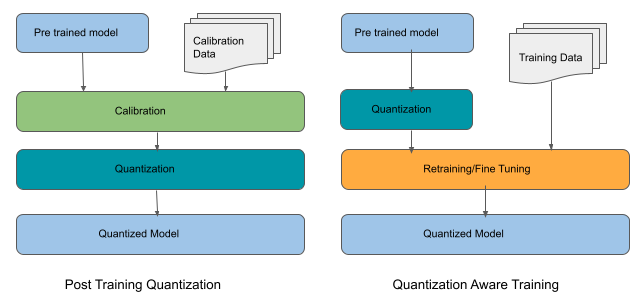

In [34]:
class qat_student_model(nn.Module):
    def __init__(self, n_C=10):
        super(qat_student_model, self).__init__()
        # QuantStub converts tensors from floating point to quantized
        self.quant = torch.ao.quantization.QuantStub()

        self.conv1 = nn.Conv2d(3, 32, kernel_size = 5)
        self.batchnorm2d_1 = nn.BatchNorm2d(32)
        self.relu_1 = nn.ReLU()
        self.maxpool2d_1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5)
        self.batchnorm2d_2 = nn.BatchNorm2d(64)
        self.relu_2 = nn.ReLU()
        self.maxpool2d_2 = nn.MaxPool2d(2)

        # Expand from one extractor to two extractor (classed and domain-classed)
        self.num_cnn_features = 64 * 4 * 4  # 1024 flattening

        # Label classification (blue section)
        self.linear_1 = nn.Linear(self.num_cnn_features, 64)
        # self.batchnorm1d = nn.BatchNorm1d(64)
        self.relu_lin1 = nn.ReLU()
        # self.dropout = nn.Dropout()

        # output logits layer (10 classes)
        self.linear_2 = nn.Linear(64, n_C)
        self.logsoftmax = nn.LogSoftmax(dim=1)

        # DeQuantStub converts tensors from quantized to floating point
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):

        # Handle single-channel input by expanding (repeating) the singleton dimension
        # MNIST (grayscale, 1-channel) to 3-channel
        x = x.expand(x.data.shape[0], channel_size, image_size, image_size)
        # print(x.shape)
        x = self.quant(x)
        x = self.maxpool2d_1(self.relu_1(self.batchnorm2d_1(self.conv1(x))))
        x = self.maxpool2d_2(self.relu_2(self.batchnorm2d_2(self.conv2(x))))
        fc = x.reshape(-1, self.num_cnn_features) #Flattening
        fc = self.relu_lin1(self.linear_1(fc))  #regular features classification
        logits = self.linear_2(fc)
        logits = self.dequant(logits)
        out = self.logsoftmax(logits)
        return out

s = qat_student_model()
print(s)

qat_student_model(
  (quant): QuantStub()
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2d_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU()
  (maxpool2d_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2d_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_2): ReLU()
  (maxpool2d_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=1024, out_features=64, bias=True)
  (relu_lin1): ReLU()
  (linear_2): Linear(in_features=64, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
  (dequant): DeQuantStub()
)


In [55]:
import torch

# define a floating point model where some layers could be statically quantized
class qat_student_model(nn.Module):
    def __init__(self, VGG, n_C=10):
        super(qat_student_model, self).__init__()
        # QuantStub converts tensors from floating point to quantized
        self.quant = torch.ao.quantization.QuantStub()

        self.VGG = VGG
        # DeQuantStub converts tensors from quantized to floating point
        self.dequant = torch.ao.quantization.DeQuantStub()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):

        # Handle single-channel input by expanding (repeating) the singleton dimension
        # MNIST (grayscale, 1-channel) to 3-channel
        x = x.expand(x.data.shape[0], channel_size, image_size, image_size).to(device)
        # print(x.shape)
        x = self.quant(x)
        
        x = self.VGG(x)
        
        x = self.dequant(x)
        x = self.logsoftmax(x)
        return x


VGG16 = torchvision.models.vgg16(pretrained=True)
VGG16.classifier[-1] = nn.Linear(in_features=4096, out_features=10)

VGG16 = VGG16.to(device)

VGG16.load_state_dict(torch.load('/home/crueang/jira/W6/cp/best_pretrainedmodel.pth', weights_only=True))  # load cp to model

VGG16.eval()
# create a model instance
model_qat_fp32 = qat_student_model(VGG16)

# model must be set to eval mode for static quantization logic to work
model_qat_fp32.eval()

print(model_qat_fp32.VGG.classifier)

modules = []
for i in range(len(model_qat_fp32.VGG.features)):
    if 'Conv' in str(type(model_qat_fp32.VGG.features[i])):
        modules.append([f'VGG.features.{i}', f'VGG.features.{i+1}'])
        i += 1

for i in range(len(model_qat_fp32.VGG.classifier)):
    if 'Linear' in str(type(model_qat_fp32.VGG.classifier[i])):
        modules.append([f'VGG.classifier.{i}', f'VGG.classifier.{i+1}'])
        i += 1

modules.pop()

# for layer in model_qat_fp32.VGG.features:
#     print('VGG.features[0]')

# attach a global qconfig, which contains information about what kind
# of observers to attach. Use 'x86' for server inference and 'qnnpack'
# for mobile inference. Other quantization configurations such as selecting
# symmetric or asymmetric quantization and MinMax or L2Norm calibration techniques
# can be specified here.
# Note: the old 'fbgemm' is still available but 'x86' is the recommended default
# for server inference.
# model_ptsq_fp32.qconfig = torch.ao.quantization.get_default_qconfig('fbgemm')
model_qat_fp32.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
# model_qat_fp32.qconfig = torch.ao.quantization.get_default_qconfig('qnnpack')

# Fuse the activations to preceding layers, where applicable.
# This needs to be done manually depending on the model architecture.
# Common fusions include `conv + relu` and `conv + batchnorm + relu`
model_qat_fp32_fused = torch.ao.quantization.fuse_modules(model_qat_fp32, modules)

# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
model_qat_fp32_prepared = torch.ao.quantization.prepare_qat(model_qat_fp32_fused.train())

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
model_qat_fp32_prepared.eval()
model_qat_int8 = torch.ao.quantization.convert(model_qat_fp32_prepared)

torch.save(model_qat_int8.state_dict(), '/home/crueang/jira/W6/cp/qat_int8.pth')

# run the model, relevant calculations will happen in int8
res = model_qat_int8(input_fp32)
print(f'tensor predicted: {res} || dtype: {res.dtype}')
# summary(model_int8, input_size=(channel_size, image_size, image_size))
# Print the total number of parameters directly (no need for .numpy() anymore)
print(f'\n\n\nint8 qat model: {model_qat_int8}')
total_params = sum(p.numel() for p in model_qat_int8.parameters())
print("\n\n\nTotal parameters of Quantization-Aware Training (QAT)):", total_params)
count_model_param_flops(model=model_qat_int8.eval(), input_res=image_size, multiply_adds=True)

/home/crueang/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/crueang/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


/home/crueang/anaconda3/lib/python3.11/site-packages/torch/ao/quantization/observer.py:221: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/home/crueang/anaconda3/lib/python3.11/site-packages/torch/ao/quantization/utils.py:376: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


tensor predicted: tensor([[-3.6161, -0.6161, -1.6161, -3.6161, -3.6161, -3.6161, -3.6161, -2.6161,
         -3.6161, -3.6161]]) || dtype: torch.float32



int8 qat model: qat_student_model(
  (quant): Quantize(scale=tensor([1.]), zero_point=tensor([0]), dtype=torch.quint8)
  (VGG): VGG(
    (features): Sequential(
      (0): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
      (1): Identity()
      (2): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
      (3): Identity()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
      (6): Identity()
      (7): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
      (8): Identity()
      (9): MaxPool2d(kernel_size=2, stride=2, pa

6121472

-------------
# Training + Quantization

#### Student batch running (Non-quantized and Quantization Dynamically, i.e., PTDQ)

In [ ]:
# Normal training (Non-Quantized)



# Optimizer and cost function
optimizer = optim.Adam(student_fn.parameters(), lr)
loss_fn = torch.nn.CrossEntropyLoss()

###########################################################################
# 1st step: Training student net
t_0 = time.time()
iter_student = 0
best_vloss = 1_000_000.
training_logs_student = {"train_student_loss": [],  "val_student_loss": [], "train_student_acc": [], "val_student_acc": []}
for epoch in range(num_epochs_student):
    train_loss, train_correct = 0, 0
    print(f'epochs {epoch+1:04d} / {num_epochs_student:04d}', end='\n============\n')

    for i, data in enumerate(Dl_tar_training_set):
    # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):
        student_fn.train()
        # zero parameters gradient to Net and optimizer
        # model.zero_grad()
        optimizer.zero_grad()

        # GPU processing source and target data
        X, y = data[0].to(device), data[1].to(device)

        yhat = student_fn(X)
        loss = loss_fn(yhat, y)                 # source classification loss

        # back-propagation (reversed grad to maximize domain loss)
        loss.backward()
        # optimization tuning
        optimizer.step()

        # #output predict from net
        student_fn.eval()
        with torch.no_grad():
          class_prediction = student_fn(X)

        print(f'[{i+1}/{len(Dl_tar_training_set)}] '
              f'student class loss: {loss.item():.4f} '
              )
        # if batch_idx == 50:
        #     print('This is just a demo, stopping...')
        #     break

        train_loss += loss.item()
        train_correct += (class_prediction.argmax(1) == y).float().sum().item()

    training_logs_student["train_student_loss"].append(train_loss / len(Dl_tar_training_set))
    training_logs_student["train_student_acc"].append(train_correct / len(Dl_tar_training_set.dataset))#.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    student_fn.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(Dl_tar_testing_set):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = student_fn(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save testing logs
        training_logs_student["val_student_loss"].append(valid_loss / len(Dl_tar_testing_set))
        training_logs_student["val_student_acc"].append(valid_correct / len(Dl_tar_testing_set.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs_student['train_student_loss'][-1]:.5f}",
            f"train acc {training_logs_student['train_student_acc'][-1]:.5f}",

            f"validate loss {training_logs_student['val_student_loss'][-1]:.5f}",
            f"validate acc {training_logs_student['val_student_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        path_save_cp = './cp/'
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(student_fn.state_dict(), path_save_cp+'best_pruned_student_model.pth')

    iter_student += 1

t_end = time.time()-t_0
print(f"Time consumption for student net (device:{device}): {t_end} sec")

plot_graph(training_logs_student)

In [ ]:
# PTDQ


# quantized model instance
student_fn.load_state_dict(torch.load('./cp/best_unquan_student_model.pth'))
model_ptdq_int8 = torch.ao.quantization.quantize_dynamic(
    student_fn,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

# inferencing
# valid_loss, valid_correct = 0, 0
# student_ptdq_int8.eval()
# with torch.no_grad():
#     for i, vdata in enumerate(Dl_tar_testing_set):
#         vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
#         print(vinputs.shape)
#         voutputs = student_ptdq_int8(vinputs)
#         vloss = loss_fn(voutputs, vlabels)
#         valid_loss += loss_fn(voutputs, vlabels).item()
#         valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
#     # save testing logs
#     training_logs_student["val_student_loss"].append(valid_loss / len(Dl_tar_testing_set))
#     training_logs_student["val_student_acc"].append(valid_correct / len(Dl_tar_testing_set.dataset))

# if epoch % 1 == 0:
#     print(f"Epochs {epoch+1}".ljust(10),
#         f"validate loss {training_logs_student['val_student_loss'][-1]:.5f}",
#         f"validate acc {training_logs_student['val_student_acc'][-1]:.5f}",
#         )
#     print("-"*80)
input_fp32 = torch.randn(1, 3, 28, 28)
res = model_ptdq_int8(input_fp32)
summary(model_ptdq_int8, input_size=(channel_size, image_size, image_size))
count_model_param_flops(model=model_ptdq_int8.eval(), input_res=28, multiply_adds=True)




AttributeError: 'function' object has no attribute 'nelement'

#### Non-quantized (FP32 training) to each quantization techniques

Use the same network at model_qat_fp32 for base model

In [ ]:
# Optimizer and cost function
optimizer = optim.Adam(model_qat_fp32.parameters(), lr)
loss_fn = torch.nn.CrossEntropyLoss()

###########################################################################
# 1st step: Training student net
t_0 = time.time()
iter_student = 0
best_vloss = 1_000_000.
training_logs_student = {"train_student_loss": [],  "val_student_loss": [], "train_student_acc": [], "val_student_acc": []}
for epoch in range(num_epochs_student):
    train_loss, train_correct = 0, 0
    print(f'epochs {epoch+1:04d} / {num_epochs_student:04d}', end='\n============\n')

    for i, data in enumerate(Dl_tar_training_set):
    # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):
        model_qat_fp32.train()
        # zero parameters gradient to Net and optimizer
        # model.zero_grad()
        optimizer.zero_grad()

        # GPU processing source and target data
        X, y = data[0].to(device), data[1].to(device)

        yhat = model_qat_fp32(X)
        loss = loss_fn(yhat, y)                 # source classification loss

        # back-propagation (reversed grad to maximize domain loss)
        loss.backward()
        # optimization tuning
        optimizer.step()

        # #output predict from net
        model_qat_fp32.eval()
        with torch.no_grad():
          class_prediction = model_qat_fp32(X)

        print(f'[{i+1}/{len(Dl_tar_training_set)}] '
              f'student class loss: {loss.item():.4f} '
              )
        # if batch_idx == 50:
        #     print('This is just a demo, stopping...')
        #     break

        train_loss += loss.item()
        train_correct += (class_prediction.argmax(1) == y).float().sum().item()

    training_logs_student["train_student_loss"].append(train_loss / len(Dl_tar_training_set))
    training_logs_student["train_student_acc"].append(train_correct / len(Dl_tar_training_set.dataset))#.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model_qat_fp32.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(Dl_tar_testing_set):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model_qat_fp32(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save testing logs
        training_logs_student["val_student_loss"].append(valid_loss / len(Dl_tar_testing_set))
        training_logs_student["val_student_acc"].append(valid_correct / len(Dl_tar_testing_set.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs_student['train_student_loss'][-1]:.5f}",
            f"train acc {training_logs_student['train_student_acc'][-1]:.5f}",

            f"validate loss {training_logs_student['val_student_loss'][-1]:.5f}",
            f"validate acc {training_logs_student['val_student_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        path_save_cp = './cp/'
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(student_fn.state_dict(), path_save_cp+'best_unquan_student_model.pth')

    iter_student += 1

t_end = time.time()-t_0
print(f"Time consumption for student net (device:{device}): {t_end} sec")






epochs 0001 / 0001
[1/29] student class loss: 2.3197 
[2/29] student class loss: 2.2215 
[3/29] student class loss: 2.1099 
[4/29] student class loss: 2.0047 
[5/29] student class loss: 1.8969 
[6/29] student class loss: 1.8221 
[7/29] student class loss: 1.7087 
[8/29] student class loss: 1.6028 
[9/29] student class loss: 1.5193 
[10/29] student class loss: 1.4336 
[11/29] student class loss: 1.3540 
[12/29] student class loss: 1.2773 
[13/29] student class loss: 1.2167 
[14/29] student class loss: 1.1342 
[15/29] student class loss: 1.0480 
[16/29] student class loss: 0.9901 
[17/29] student class loss: 0.9633 
[18/29] student class loss: 0.8538 
[19/29] student class loss: 0.8357 
[20/29] student class loss: 0.7976 
[21/29] student class loss: 0.7172 
[22/29] student class loss: 0.7081 
[23/29] student class loss: 0.6892 
[24/29] student class loss: 0.6362 
[25/29] student class loss: 0.5993 
[26/29] student class loss: 0.6093 
[27/29] student class loss: 0.5613 
[28/29] student cl

In [ ]:
# @title PTDQ (model_qat_32 --> model_ptdq_int8)


# quantized model instance
model_qat_fp32.load_state_dict(torch.load('./cp/best_unquan_student_model.pth'))
model_ptdq_int8 = torch.ao.quantization.quantize_dynamic(
    model_qat_fp32,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

# inferencing
valid_loss, valid_correct = 0, 0
with torch.no_grad():
    for i, vdata in enumerate(Dl_tar_testing_set):
        vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
        voutputs = model_ptdq_int8(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        valid_loss += loss_fn(voutputs, vlabels).item()
        valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
    # save testing logs
    print(f'test loss [PTDQ-int8-based student]: {valid_loss / len(Dl_tar_testing_set):.5f}'
          f'\ntest acc [PTDQ-int8-based student]: {valid_correct / len(Dl_tar_testing_set.dataset):.5f}')

# input_fp32 = torch.randn(1, 3, 28, 28)
# res = model_ptdq_int8(input_fp32)
# print(f'tensor predicted: {res} || dtype: {res.dtype}')

summary(model_ptdq_int8, input_size=(channel_size, image_size, image_size))
count_model_param_flops(model=model_ptdq_int8.eval(), input_res=28, multiply_adds=True)




test loss [PTDQ-int8-based student]: 2.30583
test acc [PTDQ-int8-based student]: 0.08966
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         QuantStub-1            [-1, 3, 28, 28]               0
            Conv2d-2           [-1, 32, 24, 24]           2,432
       BatchNorm2d-3           [-1, 32, 24, 24]              64
              ReLU-4           [-1, 32, 24, 24]               0
         MaxPool2d-5           [-1, 32, 12, 12]               0
            Conv2d-6             [-1, 64, 8, 8]          51,264
       BatchNorm2d-7             [-1, 64, 8, 8]             128
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                   [-1, 64]               0
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 10]               0
      DeQuantS

tensor(9431104.)

In [ ]:
# @title PTDQ (model_qat_32 --> model_qat_int8)



# model_qat_fp32 = qat_student_model()  # create a new model instance
model_qat_fp32.load_state_dict(torch.load('./cp/best_unquan_student_model.pth'))  # load cp to model
# model must be set to eval mode for static quantization logic to work
model_qat_fp32.eval()

# attach a global qconfig, which contains information about what kind
# of observers to attach. Use 'x86' for server inference and 'qnnpack'
# for mobile inference. Other quantization configurations such as selecting
# symmetric or asymmetric quantization and MinMax or L2Norm calibration techniques
# can be specified here.
# Note: the old 'fbgemm' is still available but 'x86' is the recommended default
# for server inference.
# model_ptsq_fp32.qconfig = torch.ao.quantization.get_default_qconfig('fbgemm')
model_qat_fp32.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
# model_qat_fp32.qconfig = torch.ao.quantization.get_default_qconfig('qnnpack')

# Fuse the activations to preceding layers, where applicable.
# This needs to be done manually depending on the model architecture.
# Common fusions include `conv + relu` and `conv + batchnorm + relu`
model_qat_fp32_fused = torch.ao.quantization.fuse_modules(model_qat_fp32,
                                                      [['conv1', 'batchnorm2d_1', 'relu_1'],
                                                       ['conv2', 'batchnorm2d_2', 'relu_2'],
                                                       ['linear_1', 'relu_lin1'],
                                                      #  ['linear_2']
                                                       ])

# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
model_qat_fp32_prepared = torch.ao.quantization.prepare_qat(model_qat_fp32_fused.train())

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
model_qat_fp32_prepared.eval()
model_qat_int8 = torch.ao.quantization.convert(model_qat_fp32_prepared)

# run the model, relevant calculations will happen in int8
# input_fp32 = torch.randn(1, 3, 28, 28)
# res = model_qat_int8(input_fp32)
# print(f'tensor predicted: {res} || dtype: {res.dtype}')

valid_loss, valid_correct = 0, 0
with torch.no_grad():
    for i, vdata in enumerate(Dl_tar_testing_set):
        vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
        voutputs = model_qat_int8(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        valid_loss += loss_fn(voutputs, vlabels).item()
        valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
    # save testing logs
    print(f'test loss [QAT-int8-based student]: {valid_loss / len(Dl_tar_testing_set):.5f}'
          f'\ntest acc [QAT-int8-based student]: {valid_correct / len(Dl_tar_testing_set.dataset):.5f}')


# summary(model_int8, input_size=(channel_size, image_size, image_size))
# Print the total number of parameters directly (no need for .numpy() anymore)
print(f'\n\n\nint8 ptsq model: {model_qat_int8}')
total_params = sum(p.numel() for p in model_qat_int8.parameters())
print("\n\n\nTotal parameters of Quantization-Aware Training (QAT)):", total_params)
count_model_param_flops(model=model_qat_int8.eval(), input_res=28, multiply_adds=True)

test loss [QAT-int8-based student]: 2.30259
test acc [QAT-int8-based student]: 0.09754



int8 ptsq model: qat_student_model(
  (quant): Quantize(scale=tensor([1.]), zero_point=tensor([0]), dtype=torch.quint8)
  (conv1): QuantizedConvReLU2d(3, 32, kernel_size=(5, 5), stride=(1, 1), scale=1.0, zero_point=0)
  (batchnorm2d_1): Identity()
  (relu_1): Identity()
  (maxpool2d_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): QuantizedConvReLU2d(32, 64, kernel_size=(5, 5), stride=(1, 1), scale=1.0, zero_point=0)
  (batchnorm2d_2): Identity()
  (relu_2): Identity()
  (maxpool2d_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): QuantizedLinearReLU(in_features=1024, out_features=64, scale=1.0, zero_point=0, qscheme=torch.per_channel_affine)
  (relu_lin1): Identity()
  (linear_2): QuantizedLinear(in_features=64, out_features=10, scale=1.0, zero_point=0, qscheme=torch.per_channel_affine)
  (logsoftmax): LogSoftmax(

22528

# Summary
Available techniques supported to some blocks/layers for doing dynamic and static quantization

|Layers|Static Quantization|Dynamic Quantization|
|-|-|-|
|nn.Linear|Y|Y|
|nn.Conv1d/2d/3d|Y|N|
|nn.LSTM|N|Y|
|nn.GRU|N|Y|
|nn.RNNCell|N|Y|
|nn.GRUCell|N|Y|
|nn.LSTMCell|N|Y|
|nn.EmbeddingBag|Y (activations are in fp32)|N|
|nn.Embedding|Y|Y|
|nn.MultiheadAttention|Not supported|Not supported|
|Activations|Broadly supported|Un-changed, computations stay in fp32|

# Homework
จงบีบอัดแบบ quantization ไปยัง VGG16 (Referred to W4-2) โดยให้เทียบวิธีการ

*   Non-quantized
*   Dynamic quantization (PTDQ)
*   Static quantization (PTSQ)
*   Quantization-Aware Training (QAT)


จัดส่งเป็น PDF ที่เปรียบเทียบผลตามวิธีการข้างต้น วัดผลในเชิง

*   Quantitative results (acc., precision, recall, F1, confusion matrix, etc.)
*   Computational resource in use (training time, parameters, FLOPs, etc.)
